In [1]:
import numpy as np
from scipy.linalg import eigh
from numpy import pi

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 150

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session

from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit_ibm_runtime.options import EstimatorOptions, SamplerOptions, EnvironmentOptions

# Set up backend

In [2]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
# backend = AerSimulator()

def get_noisy_simulator(single_qubit_gate_noise=0.0003, two_qubit_gate_noise=0.003):
    # adjust for values to minic real hardware numbers!
    # custom noise model
    noise_model = NoiseModel()
    single_qubit_error = depolarizing_error(single_qubit_gate_noise, 1)

    noise_model.add_all_qubit_quantum_error(single_qubit_error, ['rz', 'rx'])

    rzz_error = depolarizing_error(two_qubit_gate_noise, 2)
    noise_model.add_all_qubit_quantum_error(rzz_error, ['rzz'])
    simulator = AerSimulator(noise_model=noise_model, method='matrix_product_state',
                             matrix_product_state_max_bond_dimension = 4,
                            matrix_product_state_truncation_threshold = 1e-8)
    return simulator

backend = get_noisy_simulator()

# from qiskit_ibm_runtime.fake_provider import FakeFez
# backend = FakeFez()

# Set parameters

In [3]:
# Set system size
system_qubits = 28

# Set number of bath sites coupled to system
bath_qubits = 14

num_qubits = system_qubits + bath_qubits

# Manually set flag to select between two geometries: one bath site coupled to every system qubit or one bath site connected to every second system qubit
half = True # True if 1 bath to 2 system qubits

# Set boundary conditions for chain
open_boundary = 1 # Open boundary conditions: (1) or Periodic boundary conditions: (0)

# Set value of Ising coupling
J = 0.4

# Set value of transverse field
h = 0.6

# Set number of HVA-type circuit layers per variational cooling sweep
p = 3

# Set number of cooling sweeps to execute
num_sweeps = 1

# Set parameter values resulting from separate variational optimization

In [4]:
# J=0.45
# 3 layers
# best_para = np.array([0.2579068792545095, 0.6394665483430537, 1.6000809859220193, -0.4677029550794296, 2.251594733293615, 1.0956802728896018, 3.141592653589793, 1.92078829520187, -0.8305840116887662, 1.2839351722098988, 0.9409858928175381, 0.4159040499271145])


# J=0.4
# 3 Layers
best_para = np.array([0.026932368894753006, 0.58775691792609, 1.416345878671235, -0.5847230425335908, 2.108254043912492, 0.9685586146293224, 3.141592653589793, 1.9041272021498745, -0.7655691857212363, 1.463995846549075, 1.062269199105236, 0.450403882505529])


# Define Pauli strings that make up the system Hamiltonian

In [5]:
def Pauli_sys_ZZ(system_qubits, bath_qubits, J):
    num_qubits = system_qubits + bath_qubits
    
    pauli_str = []
    str_iter = "I"*(system_qubits-2) + "ZZ"
    
    for i in range(system_qubits-open_boundary):
        pauli_str.append("I"*bath_qubits + str_iter)
        str_iter = str_iter[1:] + str_iter[0]
    
    pauli_sys_ZZ = [(itr, -J) for itr in pauli_str]
    return pauli_sys_ZZ

def Pauli_sys_X(system_qubits, bath_qubits, h):
    num_qubits = system_qubits + bath_qubits
    
    pauli_str = []
    str_iter = "I"*(system_qubits-1) + "X"
    
    for i in range(system_qubits):
        pauli_str.append("I"*bath_qubits + str_iter)
        str_iter = str_iter[1:] + str_iter[0]
    
    pauli_sys_X = [(itr, -h) for itr in pauli_str]
    return pauli_sys_X

# Create parametrized Hamiltonian Variational Ansatz (HVA) type circuit for variational cooling sweeps

In [6]:
def hva_multiple_sweeps(p, system_qubits, bath_qubits, parameters, num_sweeps=1, reset=True, barrier=True):
    #p: number of HVA layers per sweep; each HVA layer consists of three sub-layers (H1, H2, H3) of non-commuting gates
    #num_sweeps: number of repetitions of the p-layer HVA circuit, separated by bath qubit resets

    # alpha, beta: parameterized ZZ and X rotation angles on system qubits; B_t, g_t: parameters mimicking Z-field and system-bath coupling
    # Note: parameters are taken to be translation-invariant
    alpha, beta, B_t, g_t = parameters
    num_qubits = system_qubits + bath_qubits
    
    # Barriers are included below for visualization, but should be removed to allow most efficient transpilation
    qc = QuantumCircuit(system_qubits + bath_qubits)
    for sweeps in range(num_sweeps):    
        for i in range(p):   
            
            # H_1: brick-wall layout of RZZ gates on system bonds, and Z-rotations on bath qubits
            for j in range(0, system_qubits-open_boundary, 2):
                qc.rzz(-J*alpha[i], j, (j+1)%system_qubits)
            for j in range(1, system_qubits-open_boundary, 2):
                qc.rzz(-J*alpha[i], j, (j+1)%system_qubits)                

            for j in range(system_qubits, num_qubits):
                qc.rz(-B_t[i], j)

            if barrier: qc.barrier()
            # H_2: RX rotations on system qubits
            for j in range(system_qubits):
                qc.rx(-h*beta[i], j)
    
            if barrier: qc.barrier()
            # H_3: RYY gates connecting system and bath qubits
            if half:
                for j in range(bath_qubits):
                    qc.ryy(-g_t[i], 2*j, j+system_qubits)
            else:
                for j in range(bath_qubits):
                    qc.ryy(-g_t[i], j, j+system_qubits)
            if barrier: qc.barrier()

        if reset:
            if barrier: qc.barrier()
            for k in range(bath_qubits):
                qc.reset(-k-1)
              
            if barrier: qc.barrier()                
    return qc

# Set up system Hamiltonian and find exact ground state energy (used for training)

In [7]:
# Create system Hamiltonian
pauli_sys = Pauli_sys_ZZ(system_qubits, 0, J) + Pauli_sys_X(system_qubits, 0, h)
H_sys = SparsePauliOp.from_list(pauli_sys)

# Specify qubit layout(s) on QPU and construct updated observables on enlarged circuit
The circuit is enlarged at this step for two reasons: (1) multiple copies of the circuit can be instantiated to run in parallel across the QPU, and (2) ancilla qubits are introduced to replace lossy "reset" operations

In [8]:
# Create array storing lengths of strings of system qubits, bath qubits, and ancilla qubit groupings
lengths = [p, p, p, p]

# Create list of indices telling how to split up the "best_param" list above into system, bath, and ancilla parameters (used below for constructing the parameterized circuit)
split_pts = np.cumsum(lengths)[:-1]

# Specify the total number of qubits per circuit instance, counting the ancillas used to imitate resets
tot_qubits = system_qubits + bath_qubits

# Create the observables for the enlarged circuit
H_observables = []
for pauliop in pauli_sys:
    bt_str = (bath_qubits)*"I"+ pauliop[0]
    H_observables.append((bt_str, pauliop[1]))
observables = SparsePauliOp.from_list(H_observables)

# Build circuit

In [9]:
all_circs = []
for init_state in ["0"*system_qubits, "0"*(system_qubits//2)+"1"*(system_qubits//2), 'x']: # Specify Initial state
    for tot_sweeps in range(10):
        
        # Create quantum circuit with desired number of active qubits
        total_circ = QuantumCircuit(tot_qubits)

        # # Initialize system qubits in random state in computational basis
        if init_state != 'x':
            for j in range(system_qubits):
                if int(init_state[j]):
                    total_circ.x(j)
        else:
            for j in range(system_qubits):
                total_circ.h(j)
        
        for sweeps in range(tot_sweeps):
            total_circ = total_circ.compose(hva_multiple_sweeps(p, system_qubits, bath_qubits, np.split(best_para, split_pts),
                               num_sweeps=1, reset=True), qubits = [k for k in range(tot_qubits)]) # 3 bath qubits

        all_circs.append(total_circ)

# Print desired circuit

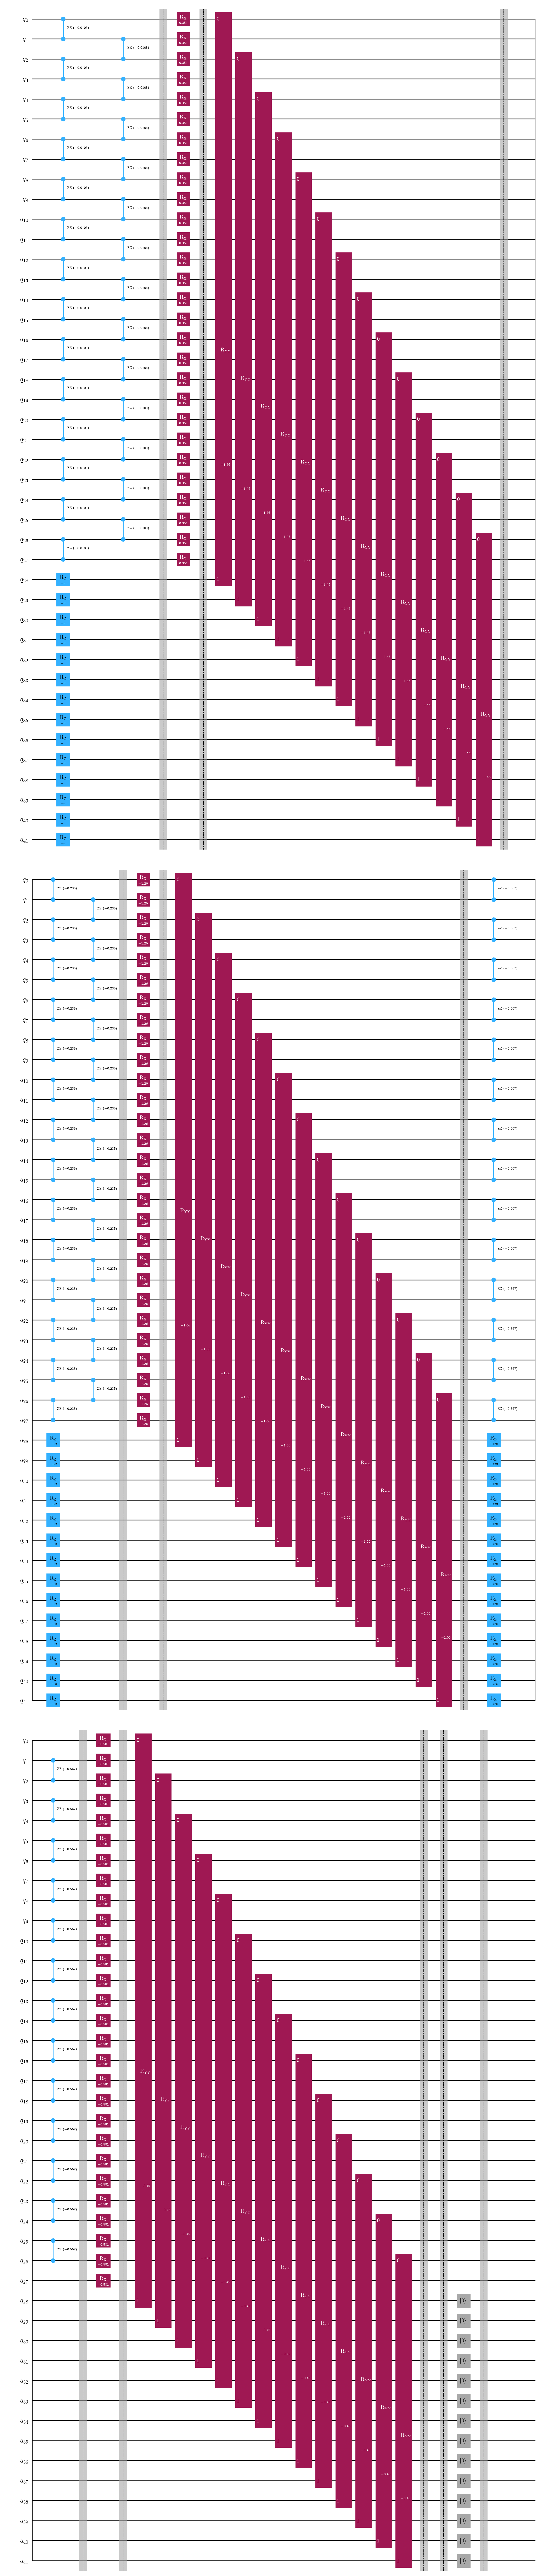

In [10]:
all_circs[1].draw('mpl', idle_wires=False)

# Set up pass manager and transpile circuit

In [11]:
# Layout

indices = [k for k in range(tot_qubits)]
bath_indices = [k for k in range(1, tot_qubits, 3)]
for bath_idx in bath_indices:
    indices.remove(bath_idx)
layout = indices + bath_indices

In [12]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, initial_layout = layout)
                                                                                           
all_transpiled = [pm.run(total_circ) for total_circ in all_circs]

mapped_observables = [observable.apply_layout(all_transpiled[0].layout) for observable in observables]

# Analyze gate count before/after transipilation

In [13]:
# #Optimization level 3
# print('Gate summary: ', dict(transpiled_circuit.count_ops()))
# print('Total number of gates: ', transpiled_circuit.size())
# print('Gate number for 1 HVA circuit:', 
#       (transpiled_circuit.size())/(num_sweeps))

# print()
# # print('Gate number for 1 HVA layer:', 
# #       (transpiled_circuit.size()-dict(transpiled_circuit.count_ops())['reset'])/(num_layouts * num_sweeps))


# print("No transpilation")
# print('Gate summary: ', dict(total_circ.count_ops()))
# print('Total number of gates: ', total_circ.size())

# Set up Estimator

In [14]:
# Estimator Options
options = EstimatorOptions()

# # Dynamical decoupling
# options.dynamical_decoupling.enable = True
# options.dynamical_decoupling.sequence_type = "XY4" # XX, XpXm, XY4
# options.dynamical_decoupling.scheduling_method = "asap" # asap, alap
# options.dynamical_decoupling.skip_reset_qubits = True

# options.dynamical_thedecoupling.qubits = [Qubits]
# options.transpilation.skip_transpilation = True

# options.twirling.enable_gates = True
# options.resilience.measure_mitigation = True

# options.resilience_level = 1   # T-REx

    # options.resilience.zne_mitigation = True
    # options.resilience.zne.noise_factors = (1, 3, 5)
    # options.resilience.zne.extrapolator = "exponential"

options.max_execution_time = 30 #seconds    

estimator = Estimator(mode=backend, options = options)
estimator.options.default_shots = 8192

# Draw transpiled circuit

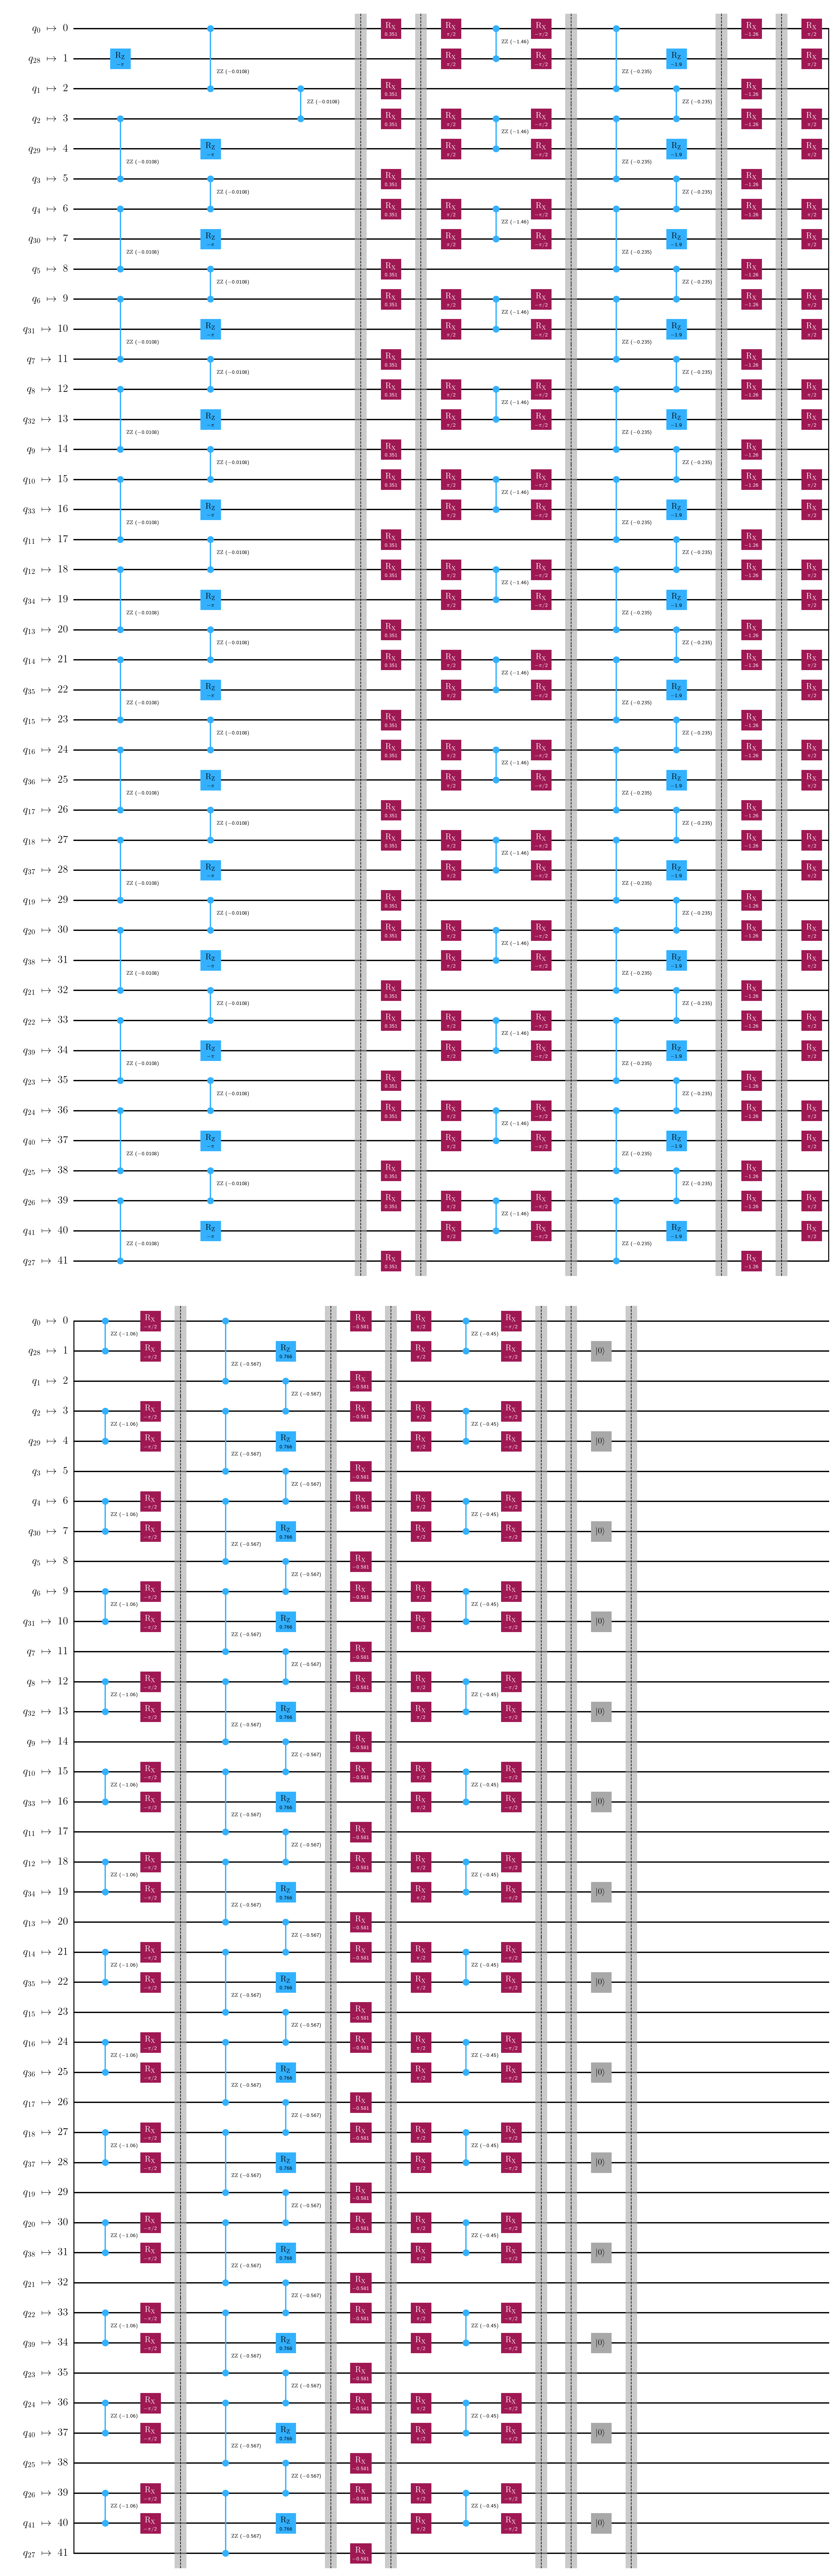

In [16]:
all_transpiled[1].draw('mpl', idle_wires=False)

# Run circuit

In [ ]:
jobs = []

for transpiled_circuit in all_transpiled:
    job = estimator.run([(transpiled_circuit, mapped_observables)])
    # print(job.usage_estimation)
    jobs.append(job)
    
    pub_result = job.result()[0]
    values = pub_result.data.evs
    
    # Energies for subcircuits
    size = len(pauli_sys)
    result = sum(values)
    print(result)

# for job in jobs:
#     pub_result = job.result()[0]
#     values = pub_result.data.evs
    
#     # Energies for subcircuits
#     size = len(pauli_sys)
#     result = [sum(values[size*i:size*i + size]) for i in range(num_layouts)]
#     print(np.array(result))
#     errors = pub_result.data.stds
    
#     # with open('blank.txt', 'w') as f:
#     #     f.write("values = " + repr(values) + "\n\n")
#     #     f.write("energies = " + repr(result) + "\n\n")
#     #     f.write("std_error = " + repr(errors) + "\n\n")


-10.758403515195907
-12.772220187965335
